In [17]:
import pandas as pd
#import pickle
import joblib
from fmp_python.fmp import FMP
import ssl
import time
from urllib.request import urlopen
from urllib.parse import urlencode
import certifi
import json
import os
import config
#import tempfile
#from sklearn.preprocessing import MinMaxScaler

#import optuna
#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/Users/anthonydillon/Ironhack/wk8/project/venv-final-project/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [175]:
# Variables

context = ssl.create_default_context(cafile=certifi.where())
apikey = os.getenv('FMP_SECRET_KEY')

watchlist = ['AMZN', 'AAPL', 'GOOG', 'META','MSFT', 'NVDA', 'TSLA']
indicators = ['dema', 'tema', 'williams', 'rsi', 'adx']
features = ['vwap', 'dema', 'tema', 'williams', 'rsi', 'ratingScore', 'minus_10_price', 'minus_5_price', 'minus_4_price', 'minus_3_price', 'minus_2_price']
target = ['target']
close = ['close']

In [19]:
print(apikey)

A8nw0ZRk5pklqvIiAfgBsTckdIorJ07q


In [197]:
# Functions

def company_profile_url(ticker, apikey=apikey):
    endpoint = 'https://financialmodelingprep.com/api/v3/profile/'
    url = f'{endpoint}{ticker}?apikey={apikey}'
    return url

def stock_screener(apikey=apikey, **kwargs):
    endpoint = 'https://financialmodelingprep.com/api/v3/stock-screener'
    params = {'apikey': apikey}
    params.update(kwargs)
    query_string = urlencode(params)
    url = f'{endpoint}?{query_string}'
    return url

# REMOVE???
def full_quote_url(ticker, apikey=apikey):
    endpoint = 'https://financialmodelingprep.com/api/v3/quote/'
    url = f'{endpoint}{ticker}?apikey={apikey}'
    return url

def historical_url(ticker, apikey=apikey, **kwargs):
    endpoint = 'https://financialmodelingprep.com/api/v3/historical-price-full/'
    params = {'apikey': apikey}
    params.update(kwargs)
    query_string = urlencode(params)
    #url = f'{endpoint}{ticker}?apikey={query_string}'
    url = f'{endpoint}{ticker}?{query_string}'
    return url

def technical_indicator_url(timeframe, ticker, ind_type, period, apikey=apikey, **kwargs):
    endpoint = 'https://financialmodelingprep.com/api/v3/technical_indicator/'
    params = {
        'apikey': apikey,
        'type': ind_type,
        'period': period
    }
    params.update(kwargs)
    query_string = urlencode(params)
    url = f'{endpoint}{timeframe}/{ticker}?{query_string}'
    return url

def historical_rating_url(ticker, apikey=apikey, **kwargs):
    endpoint = 'https://financialmodelingprep.com/api/v3/historical-rating/'
    params = {'apikey': apikey}
    params.update(kwargs)
    query_string = urlencode(params)
    url = f'{endpoint}{ticker}?{query_string}'
    return url

def get_jsonparsed_data(url, retries=3, timeout=10):
    """
    Fetch JSON data from the provided URL and return it as a Python dictionary.
    
    Parameters
    ----------
    url : str
        The URL to fetch data from.
    retries : int
        The number of retries for the request in case of failure.
    timeout : int
        The timeout for the request in seconds.

    Returns
    -------
    dict
        The parsed JSON data.
    """
    context = ssl.create_default_context(cafile=certifi.where())
    for attempt in range(retries):
        try:
            with urlopen(url, context=context, timeout=timeout) as response:
                data = response.read().decode("utf-8")
                return json.loads(data)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                raise

def display_company_logo(ticker, apikey=apikey, retries=3, timeout=10):
    endpoint = 'https://financialmodelingprep.com/image-stock/'
    url = f'{endpoint}{ticker}.png?apikey={apikey}'
    print(url)
    for attempt in range(retries):
        try:
            with urlopen(url, context=context) as response:
                image_data = response.read()
                display(Image(image_data))
        except Exception as e:
            print(f"Error fetching image: {e}")


def get_indicators(ticker, indicators=indicators, timeframe='1day', period=14, apikey=apikey, **kwargs):
    urls = {}
    for indicator in indicators:
        url = technical_indicator_url(timeframe, ticker, indicator, period, apikey, **kwargs)
        urls[indicator] = url
    
    ind_data = {}
    for key, value in urls.items():
        data = get_jsonparsed_data(value)
        filtered_data = [{'date': entry['date'], key: entry[key]} for entry in data if key in entry]
        ind_data[key] = filtered_data
    
    df_list = []
    for indicator, data in ind_data.items():
        df = pd.DataFrame(data)
        df = df.set_index('date')
        df_list.append(df)

    final_df = pd.concat(df_list, axis=1, join='outer')
    final_df.index = pd.to_datetime(final_df.index)
        
    return final_df

def stock_summary_table(stock_data):
    columns = stock_data[0]
    table = pd.DataFrame(stock_data)[['symbol', 'name', 'price', 'marketCap', 'exchange']]
    melted = table.melt().set_index('variable', drop=True)
    return melted


def get_all_data(ticker, **kwargs):
    data = get_jsonparsed_data(historical_url(ticker, **kwargs))
    data = data['historical']
    
    # List of keys to keep in each dictionary
    keys_to_keep = ['date', 'open', 'high', 'low', 'close', 'volume', 'vwap']

    # Modify each entry in the historical list
    for entry in data:
            
        # Keep only the necessary keys
        for key in list(entry.keys()):
            if key not in keys_to_keep:
                del entry[key]

    data = pd.DataFrame(data).set_index('date', drop=True)
    data.index = pd.to_datetime(data.index)
    return data


def get_historical_rating(ticker):
    data = get_jsonparsed_data(historical_rating_url('GOOG'))
    data = pd.DataFrame(data)[['date', 'ratingScore']]
    data = data.set_index('date', drop=True)
    data = data[data.index >= '2024-01-01']
    data.index = pd.to_datetime(data.index)
    data = data.sort_values('date')
    return data


def lagging_features_target(df):
    df = df.copy()
    df['minus_10_price'] = df.close.shift(10)
    df['minus_5_price'] = df.close.shift(5)
    df['minus_5_price'] = df.close.shift(5)
    df['minus_4_price'] = df.close.shift(4)
    df['minus_3_price'] = df.close.shift(3)
    df['minus_2_price'] = df.close.shift(2)
    #df['target'] = df.close.shift(-3)
    df = df.dropna()
    return df


def combine_data(ticker, **kwargs):
    price_data = get_all_data(ticker, **kwargs)
    ind_data = get_indicators(ticker, **kwargs)
    hist_rating_data = get_historical_rating(ticker)
    df = pd.concat([price_data, ind_data, hist_rating_data], axis=1)
    df = lagging_features_target(df)
    df = df.asfreq('D', method='ffill')
    return df


#def predict_df(pred, features):
#    predictions = pd.DataFrame(pred, index=features.index).rename(columns={0: 'price'})
#    full_index = pd.date_range(start=predictions.index.min(), end=predictions.index.max() + pd.Timedelta(days=3), freq='D')
#    predictions = predictions.reindex(full_index)
#    predictions['price'] = predictions['price'].shift(3)
#    predictions = predictions.dropna()
#    return predictions


def predict_df(pred, close):
    predictions = close.copy()
    predictions['prediction'] = pred
    full_index = pd.date_range(start=predictions.index.min(), end=predictions.index.max() + pd.Timedelta(days=3), freq='D')
    predictions = predictions.reindex(full_index)
    predictions['prediction'] = predictions['prediction'].shift(3)
    predictions.close = predictions.close.fillna(predictions.prediction)
    return predictions[['close']]


def feature_close_split(df, features=features, close=close):
    features = df[features]
    close = df[close]
    return features, close


def predict(ticker, df):
    features, close = feature_close_split(df)
    
    models = {
        'GOOG': 'alphabet_stacking_regressor_model.pkl',
        'AMZN': 'amazon_stacking_regressor_model.pkl',
        'AAPL': 'apple_stacking_regressor_model.pkl',
        'META': 'meta_stacking_regressor_model.pkl',
        'MSFT': 'microsoft_stacking_regressor_model.pkl',
        'NVDA': 'nvidia_stacking_regressor_model.pkl',
        'TSLA': 'tesla_stacking_regressor_model.pkl'
    }

    scalers = {
        'GOOG': 'alphabet_normalizer.pkl',
        'AMZN': 'amazon_normalizer.pkl',
        'AAPL': 'apple_normalizer.pkl',
        'META': 'meta_normalizer.pkl',
        'MSFT': 'microsoft_normalizer.pkl',
        'NVDA': 'nvidia_normalizer.pkl',
        'TSLA': 'tesla_normalizer.pkl'
    }

    scaler = joblib.load('../scalers/' + scalers['GOOG'])
    model = joblib.load('../models/' + models['GOOG'])

    # Normalize features
    features_norm = scaler.transform(features)
    features_norm_df = pd.DataFrame(features_norm, columns=features.columns, index=features.index)

    # Make predictions
    pred = model.predict(features_norm_df)

    df = predict_df(pred, close)

    return df


def make_chart(df):
    predicted_points = 3
    
    fig = go.Figure()
    
    # Add the actual data line
    fig.add_trace(go.Scatter(x=df.index[:-predicted_points], y=df['close'][:-predicted_points], mode='lines', name='Actual'))
    
    # Add the predicted data line
    fig.add_trace(go.Scatter(x=df.index[-predicted_points-1:], y=df['close'][-predicted_points-1:], mode='lines', name='Predicted', line=dict(color='red')))
    
    # Highlight the predicted section
    fig.add_vrect(
        x0=df.index[-predicted_points-1], x1=pred.index[-1],
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0
    )
    
    fig.update_layout(xaxis_title='Date',
                      yaxis_title='Price')

    return fig

# Collect data
1. Make an API call to retrieve historical data for the last 30 days
2. Make an API call to retrieve technical indicator data for the last 30 days
3. Format data to match what the model expects
4. Predict with the model
5. Create a chart with the predictions

In [121]:
get_historical_rating('GOOG')

,ratingScore
date,
2024-01-02,5
2024-01-03,5
2024-01-04,5
2024-01-05,5
2024-01-08,5
...,...
2024-06-24,4
2024-06-25,4
2024-06-26,4


In [ ]:
params = {
    'from': '2024-01-01',
    'to': '2024-06-28'
}

all_data = combine_data('AMZN', **params).sort_values(by='date')

In [207]:
all_data = all_data.iloc[-30:]
all_data

,open,high,low,close,volume,vwap,dema,tema,williams,rsi,adx,ratingScore,minus_10_price,minus_5_price,minus_4_price,minus_3_price,minus_2_price
date,,,,,,,,,,,,,,,,,
2024-04-30,181.09,182.99,174.80,175.00,94639786,178.4700,177.664919,176.176296,-62.985075,43.960961,23.940331,5.0,183.32,179.54,176.59,173.67,179.62
2024-05-01,181.64,185.15,176.56,179.00,94645148,180.5875,177.847222,176.710786,-43.316942,49.923865,22.845684,5.0,181.28,176.59,173.67,179.62,180.96
2024-05-02,180.85,185.10,179.91,184.72,54303510,182.6450,179.428290,179.148940,-17.746983,56.974298,21.829227,5.0,179.22,173.67,179.62,180.96,175.00
2024-05-03,186.99,187.87,185.42,186.21,39172004,186.6225,181.080767,181.522562,-7.703016,58.609099,20.277858,5.0,174.63,179.62,180.96,175.00,179.00
2024-05-04,186.99,187.87,185.42,186.21,39172004,186.6225,181.080767,181.522562,-7.703016,58.609099,20.277858,5.0,174.63,179.62,180.96,175.00,179.00
2024-05-05,186.99,187.87,185.42,186.21,39172004,186.6225,181.080767,181.522562,-7.703016,58.609099,20.277858,5.0,174.63,179.62,180.96,175.00,179.00
2024-05-06,186.28,188.75,184.80,188.70,34725295,187.1325,183.032881,184.171385,-0.222916,61.258291,19.028153,4.0,177.23,180.96,175.00,179.00,184.72
2024-05-07,188.92,189.94,187.31,188.76,34048902,188.7325,184.614817,186.154212,-4.995766,61.322530,18.128074,4.0,179.54,175.00,179.00,184.72,186.21
2024-05-08,187.44,188.43,186.39,188.00,26136350,187.5650,185.687564,187.330031,-8.213378,59.966162,17.062164,4.0,176.59,179.00,184.72,186.21,188.70


In [200]:
pred = predict('AMZN', all_data)
pred

,close
2024-01-17,151.710000
2024-01-18,153.500000
2024-01-19,155.340000
2024-01-20,155.340000
2024-01-21,155.340000
...,...
2024-06-27,197.850000
2024-06-28,193.250000
2024-06-29,192.576897
2024-06-30,198.671286


In [201]:
all_data.tail()

,open,high,low,close,volume,vwap,dema,tema,williams,rsi,adx,ratingScore,minus_10_price,minus_5_price,minus_4_price,minus_3_price,minus_2_price
date,,,,,,,,,,,,,,,,,
2024-06-24,189.33,191.00,185.33,185.57,50610379,187.8075,185.944785,186.558758,-37.293956,53.350689,12.457241,4.0,184.30,183.66,184.06,182.81,186.10
2024-06-25,186.81,188.84,185.42,186.34,45898475,186.8525,186.177019,186.730859,-38.040816,54.803696,13.782265,4.0,187.06,184.06,182.81,186.10,189.08
2024-06-26,186.92,194.80,186.26,193.61,65103893,190.3975,188.163772,189.369931,-8.762887,65.674613,16.168688,4.0,187.23,182.81,186.10,189.08,185.57
2024-06-27,195.01,199.84,194.20,197.85,74397491,196.7250,190.808155,192.792405,-10.687433,70.179594,19.048628,4.0,186.89,186.10,189.08,185.57,186.34
2024-06-28,197.73,198.85,192.50,193.25,76897093,195.5825,191.774680,193.691073,-35.392052,60.849031,21.051089,4.0,183.83,189.08,185.57,186.34,193.61


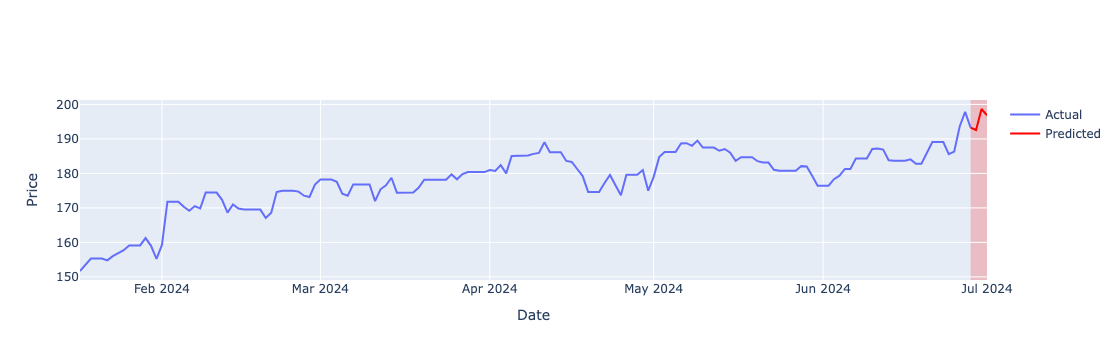

In [202]:
make_chart(pred)

In [48]:
stock_screener(**params)

('apikey=A8nw0ZRk5pklqvIiAfgBsTckdIorJ07q&from=2024-01-01&to=2024-06-28',
 'https://financialmodelingprep.com/api/v3/stock-screener?apikey=A8nw0ZRk5pklqvIiAfgBsTckdIorJ07q&from=2024-01-01&to=2024-06-28')